In [89]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from scipy.io import loadmat
import scipy.signal as sp
import scipy.optimize as op
import nanosphere_utils as ns
import importlib
from matplotlib.backends.backend_pdf import PdfPages

In [84]:
data_path = '/Users/dcmoore/Desktop/nanosphere_data/' #"/Volumes/DATA/nanosphere_data"

data_folder = '20240724_minus_one_e_data/20240724_50v_1_8e-8mbar'

plots_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/nanospheres/analysis'


In [86]:
combined_path = os.path.join(data_path, data_folder, '**/*.mat')
data_files = glob.glob(combined_path, recursive=True)

In [87]:
print(data_files)

['/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_4.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_1.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_3.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_2.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005_3.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005_2.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005_1.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_41806/3425558172.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time = np.arange(0, len(sphere_z)*tstep, tstep)


Working on impulse at time:  0.2698330031532947
38.1899521932347 12


ValueError: too many values to unpack (expected 4)

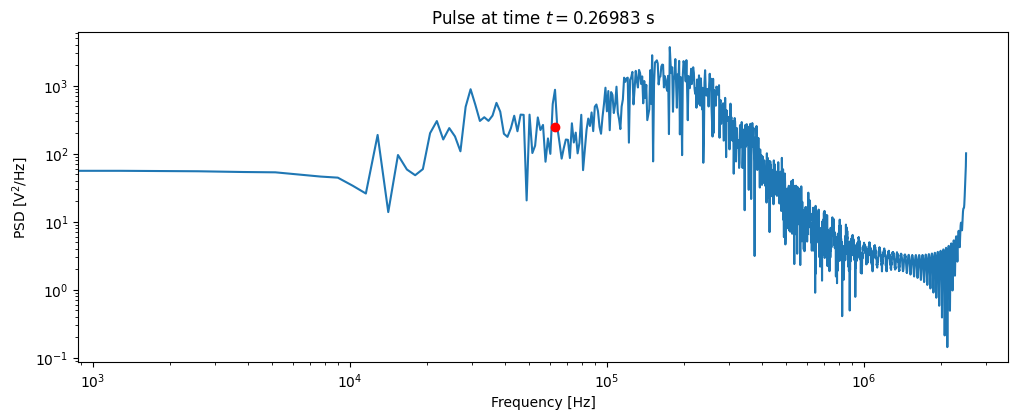

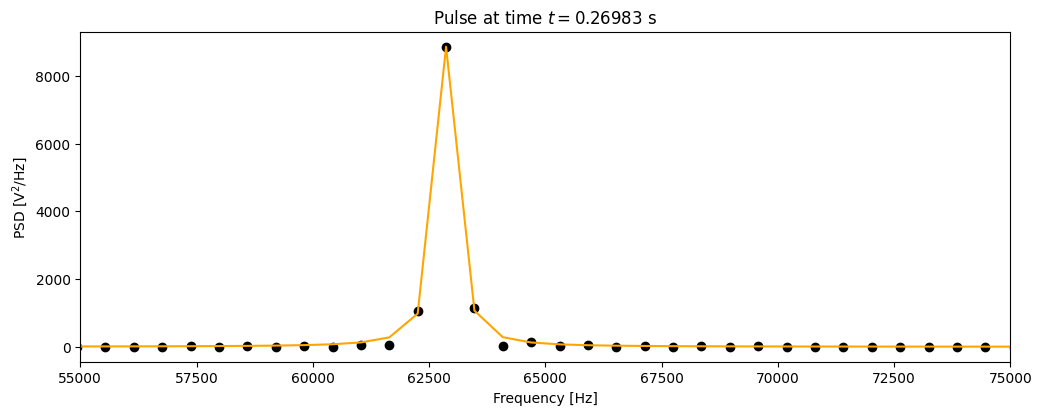

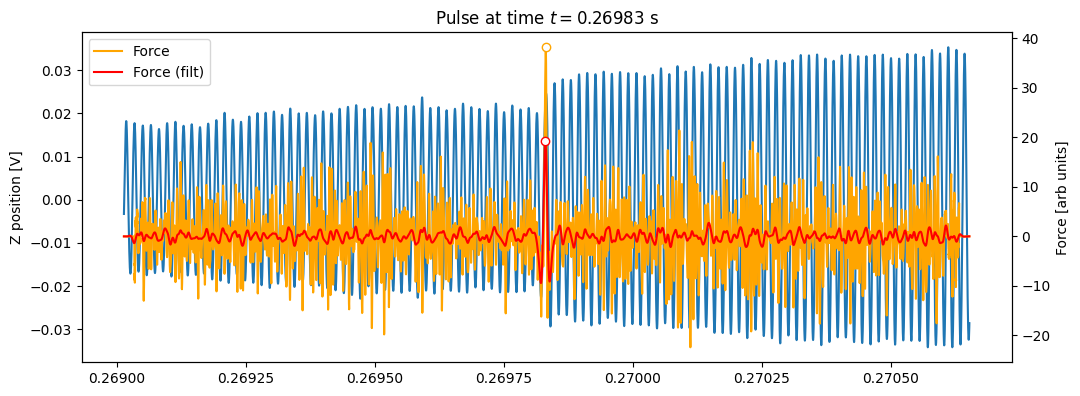

In [104]:
importlib.reload(ns)

save_plot = True

filt_band = [25e3, 200e3]
wind_size = 1e-3 ## fitting window in seconds
omega0 = 2*np.pi*64.5e3 ## resonant frequency guess
low_pass_freq = 80e3 ## low pass filter frequency

fit_amps = []
noise_amps = []

if(save_plot):
    curr_plots_path = os.path.join(plots_path, data_folder)   
    if not os.path.exists(curr_plots_path):
        os.makedirs(curr_plots_path)

tf_sig_pdf = PdfPages(os.path.join(curr_plots_path, 'transfer_func_fit_calibration.pdf'))
psd_sig_pdf = PdfPages(os.path.join(curr_plots_path, 'force_psd_calibration.pdf'))
waveform_sig_pdf = PdfPages(os.path.join(curr_plots_path, 'waveform_psd_calibration.pdf'))
tf_noise_pdf = PdfPages(os.path.join(curr_plots_path, 'transfer_func_fit_noise.pdf'))
psd_noise_pdf = PdfPages(os.path.join(curr_plots_path, 'force_psd_noise.pdf'))
waveform_noise_pdf = PdfPages(os.path.join(curr_plots_path, 'waveform_psd_noise.pdf'))

for data_file in data_files:
    data = loadmat(data_file)

    sphere_z = np.ndarray.flatten(data['D'])
    drive = np.ndarray.flatten(data['G'])
    tstep = data['Tinterval'][0]
    time = np.arange(0, len(sphere_z)*tstep, tstep)

    filtered_data = ns.get_filtered_data(time, sphere_z, drive, filt_band, tstep, make_plot=False) 
    ns.get_psd(sphere_z, tstep, filtered_data = filtered_data, make_plot = False)

    ## now find the impulses and step through each one, plotting and fitting
    impulse_idxs = ns.find_impulses(drive, make_plot=False)

    if(save_plot):
        tf_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))
        psd_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))
        waveform_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))


    for plot_idx, idx in enumerate(impulse_idxs):

        print("Working on impulse at time: ", time[idx])    

        curr_window = [time[idx]-wind_size, time[idx]+wind_size]

        if(save_plot):

            plt.figure(tf_fig.number)
            plt.subplot(len(impulse_idxs), 1, plot_idx+1)
            tf_ax = plt.gca()

            plt.figure(psd_fig.number)
            plt.subplot(len(impulse_idxs), 1, plot_idx+1)
            psd_ax = plt.gca()

            plt.figure(waveform_fig.number)
            plt.subplot(len(impulse_idxs), 1, plot_idx+1)
            waveform_ax = plt.gca()

            ax_list = [tf_ax, psd_ax, waveform_ax]

        amp, amp_lp, force_norm, f0, gamma = ns.deconvolve_force_amp(time, filtered_data, curr_window, lp_freq=low_pass_freq, make_plot=save_plot, ax_list=ax_list)

        fit_amps.append([amp, amp_lp, force_norm, f0, gamma])

    if(save_plot):
        for cfile, cfig in zip([tf_sig_pdf, psd_sig_pdf, waveform_sig_pdf], [tf_fig, psd_fig, waveform_fig]):
            plt.figure(cfig.number)
            plt.tight_layout()
            plt.subplots_adjust(top=0.95)
            plt.suptitle(data_file.removeprefix(data_path))
            cfile.savefig(cfig)



    noise_idxs = impulse_idxs[:-1] + 0.75*np.diff(impulse_idxs) ## go away from pulse time

    if(save_plot):
        tf_fig_noise = plt.figure(figsize = (12, len(noise_idxs)*5))
        psd_fig_noise = plt.figure(figsize = (12, len(noise_idxs)*5))
        waveform_fig_noise = plt.figure(figsize = (12, len(noise_idxs)*5))

    for plot_idx, nidx in enumerate(noise_idxs):
        
        nidx = int(nidx)
        print("Working on noise at time: ", time[nidx])    

        curr_window = [time[nidx]-wind_size, time[nidx]+wind_size]

        if(save_plot):

            plt.figure(tf_fig_noise.number)
            plt.subplot(len(noise_idxs), 1, plot_idx+1)
            tf_ax = plt.gca()

            plt.figure(psd_fig_noise.number)
            plt.subplot(len(noise_idxs), 1, plot_idx+1)
            psd_ax = plt.gca()

            plt.figure(waveform_fig_noise.number)
            plt.subplot(len(noise_idxs), 1, plot_idx+1)
            waveform_ax = plt.gca()

            ax_list = [tf_ax, psd_ax, waveform_ax]
        
        amp, amp_lp, force_norm, f0, gamma = ns.deconvolve_force_amp(time, filtered_data, curr_window, lp_freq=low_pass_freq, make_plot=save_plot, ax_list=ax_list)

        noise_amps.append([amp, amp_lp, force_norm, f0, gamma])

    if(save_plot):
        for cfile, cfig in zip([tf_noise_pdf, psd_noise_pdf, waveform_noise_pdf], [tf_fig_noise, psd_fig_noise, waveform_fig_noise]):
            plt.figure(cfig.number)
            plt.tight_layout()
            plt.subplots_adjust(top=0.95)
            plt.suptitle(data_file.removeprefix(data_path))
            cfile.savefig(cfig)

if(save_plot):
    pdf_list = [tf_sig_pdf, psd_sig_pdf, waveform_sig_pdf, tf_noise_pdf, psd_noise_pdf, waveform_noise_pdf]
    for pdf in pdf_list:
        pdf.close()
    plt.close('all')

fit_amps = np.array(fit_amps)
noise_amps = np.array(noise_amps)

In [64]:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

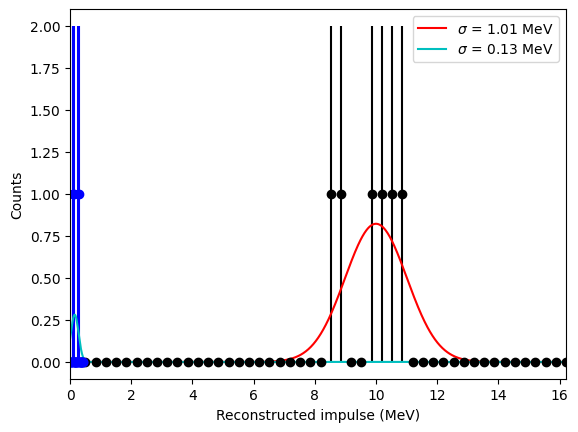

In [74]:
bins = np.linspace(0, np.max(np.abs(fit_amps[:,1]))*1.5, 50)
hh, be = np.histogram(np.abs(fit_amps[:,1]), bins=bins)
bc = 0.5*(be[1:]+be[:-1])

gp, gcov = op.curve_fit(gauss, bc, hh, p0=[np.max(hh), np.mean(np.abs(fit_amps[:,1])), np.std(np.abs(fit_amps[:,1]))])

cal_fac = 10.0/gp[1]

xx = np.linspace(0,np.max(bc),1000)

noise_bins = np.linspace(0, np.max(np.abs(noise_amps[:,1]))*1.5, 30)
hh_noise, be = np.histogram(np.abs(noise_amps[:,1]), bins=noise_bins)
bc_noise = 0.5*(be[1:]+be[:-1])
gp_noise, gcov_noise = op.curve_fit(gauss, bc_noise, hh_noise, p0=[np.max(hh_noise), np.mean(np.abs(noise_amps[:,1])), np.std(np.abs(noise_amps[:,1]))])

xx_noise = np.linspace(0,np.max(bc_noise),1000)

plt.figure()
plt.errorbar(bc*cal_fac, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(xx*cal_fac, gauss(xx, *gp), 'r', label="$\sigma$ = %.2f MeV" % (gp[2]*cal_fac))
plt.errorbar(bc_noise*cal_fac, hh_noise, yerr=np.sqrt(hh_noise), fmt='bo')
plt.plot(xx*cal_fac, gauss(xx, *gp_noise), 'c', label="$\sigma$ = %.2f MeV" % (gp_noise[2]*cal_fac))
plt.xlim(0,np.max(bc)*cal_fac)
plt.xlabel("Reconstructed impulse (MeV)")
plt.ylabel("Counts")
plt.legend()
plt.show()
